# Galaxy Cluster Redshift Classification Using Machine Learning

Spring 2024 - PHYS 2550 - Final Project

*Jade Ducharme, Zacharias Escalante, Fei Fan, Soren Helhoski, Shi Yan*

This project aims to develop a machine learning model for classifying the redshifts of background
galaxies behind galaxy clusters using observational cosmology. By leveraging photometric proper-
ties of stars and galaxies, the project seeks to calculate new redshift values for each galaxy and
compare these with known spectroscopic redshift values to evaluate the model’s accuracy.

In [1]:
# import necessary packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"    # in case of library conflict, was unable to run program without this (Feifan)

import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

## Preprocessing

In [2]:
# Load data
from preprocess import load

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag")

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51295, 7)
Label size [input_size,]:		 (51295,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


Let's visualize our inputs. First, we can plot the 1D histogram for any of our input features:

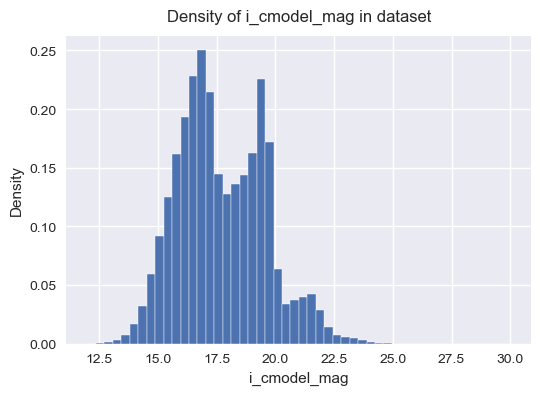

In [3]:
# Input visualization
from visualize import histogram_input

histogram_input(data, features, plot_feature="i_cmodel_mag", nbins=50, xrange=(12,30))

    

Next, we can also view how our labels align with any of the features in a 2D plot:

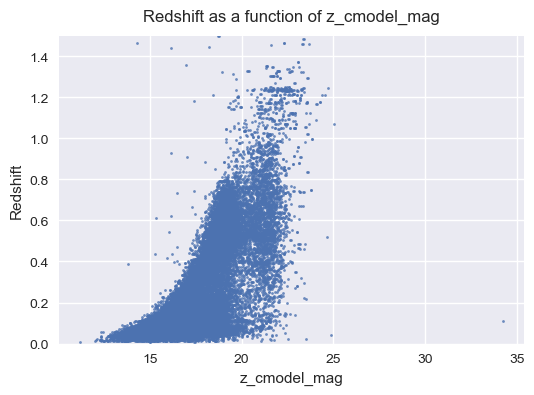

In [4]:
from visualize import plot_labels_features

plot_labels_features(data, labels, features, plot_feature="z_cmodel_mag", yrange=(0,1.5))

## Simple FCNN

As a first step, we would like to see how a simple FCNN performs.

In [5]:
from preprocess import preprocess_split
from model import SimpleFCNN, train_one_epoch, test

# model initialization
simple_fcnn = SimpleFCNN(num_features=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_fcnn.parameters(), lr=0.01)
acc_metric = torchmetrics.R2Score()  # TODO: maybe find a better accuracy metric?

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Device:",device,"\n")
simple_fcnn.to(device)

# Data preparation
train_set, val_set, test_set = preprocess_split(data, labels, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

num_epochs = 50
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch(simple_fcnn, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test(simple_fcnn, device, val_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )

Device: cpu 

Epoch 05	 Train loss: 0.0577	 Train acc: -3.0536	Val loss: 0.0429	 Val acc: -3.0389
Epoch 10	 Train loss: 0.0618	 Train acc: -3.0891	Val loss: 0.0422	 Val acc: -3.0748
Epoch 15	 Train loss: 0.0541	 Train acc: -2.9165	Val loss: 0.0379	 Val acc: -2.9359
Epoch 20	 Train loss: 0.0555	 Train acc: -2.9084	Val loss: 0.0357	 Val acc: -2.9072
Epoch 25	 Train loss: 0.0568	 Train acc: -2.8826	Val loss: 0.0388	 Val acc: -2.8783
Epoch 30	 Train loss: 0.0587	 Train acc: -2.8398	Val loss: 0.0397	 Val acc: -2.8350
Epoch 35	 Train loss: 0.0645	 Train acc: -2.8367	Val loss: 0.0455	 Val acc: -2.8330
Epoch 40	 Train loss: 0.0580	 Train acc: -2.8445	Val loss: 0.0380	 Val acc: -2.8454
Epoch 45	 Train loss: 0.0544	 Train acc: -2.8448	Val loss: 0.0430	 Val acc: -2.8425
Epoch 50	 Train loss: 0.0554	 Train acc: -2.8372	Val loss: 0.0352	 Val acc: -2.8358


In [7]:
# How does the model perform on unseen data?

test_loss, test_acc = test(simple_fcnn, device, test_loader, criterion, acc_metric)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.0246	 Final test acc: -2.8399


Next, we would like to visualize how our training went!

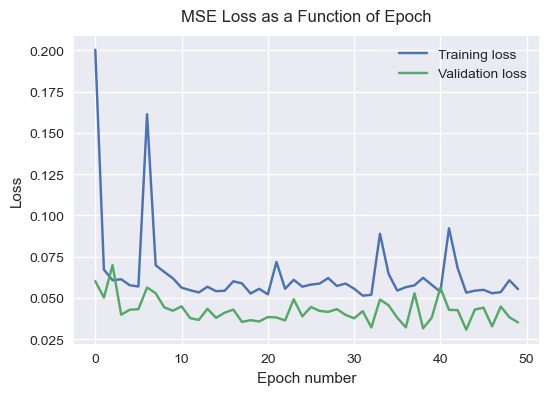

In [8]:
from visualize import plot_loss, plot_accuracy

plot_loss(loss_list, val_loss_list)

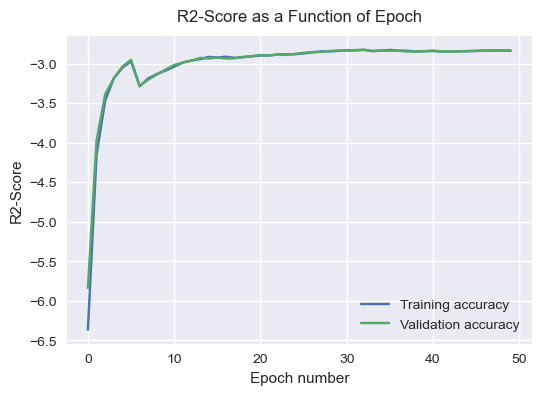

In [9]:
plot_accuracy(acc_list, val_acc_list)

Next, we would like to visualize the results of the model. In other words, given our set of test inputs, what kinds of outputs does our model predict?

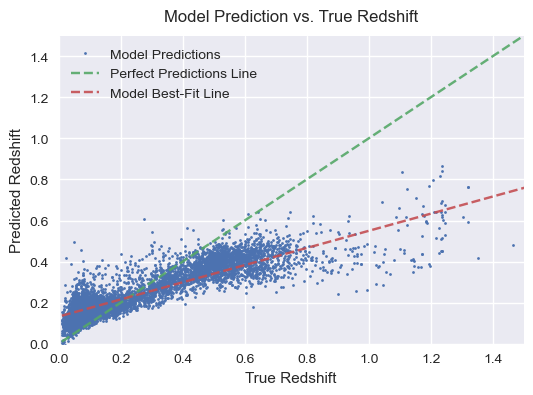

In [10]:
from visualize import visualize_predictions

visualize_predictions(test_set, simple_fcnn, device=device, xrange=(0,1.5), yrange=(0,1.5))

## 1D CNN

In [5]:
from preprocess import preprocess_split
from model import Simple1DCNN, train1D, test1D, train_one_epoch, test

# model initialization
model = Simple1DCNN(num_features=len(features), num_classes=1)

# Define the loss function and optimizer with weight decay
weight_decay = 1e-6  # Adjust this value as needed
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)  # Adding weight decay to Adam optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.000001)
acc_metric = torchmetrics.R2Score()


# Determine the device (CPU or GPU) for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The device is determined based on the availability of CUDA (GPU support) using torch.device.

# Data preparation
train_set, val_set, test_set = preprocess_split(data, labels, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

# Train the model
num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []


for e in range(1,num_epochs+1):

    # training
    loss, acc = train1D(model, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test1D(model, device, test_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f'Epoch {e}: Train Loss: {loss:.4f}, Train Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1: Train Loss: 42.0479, Train Acc: -91.7624, Val Loss: 35.1170, Val Acc: -82.8242
Epoch 2: Train Loss: 29.2834, Train Acc: -63.9174, Val Loss: 23.5585, Val Acc: -53.1233
Epoch 3: Train Loss: 18.8228, Train Acc: -39.8834, Val Loss: 14.2973, Val Acc: -30.4772
Epoch 4: Train Loss: 10.6959, Train Acc: -21.4699, Val Loss: 7.3532, Val Acc: -14.9928
Epoch 5: Train Loss: 4.8929, Train Acc: -9.3382, Val Loss: 2.7353, Val Acc: -4.9854
Epoch 6: Train Loss: 1.4121, Train Acc: -2.1374, Val Loss: 0.4251, Val Acc: -0.3998
Epoch 7: Train Loss: 0.1579, Train Acc: -0.0947, Val Loss: 0.0814, Val Acc: -0.1027
Epoch 8: Train Loss: 0.0860, Train Acc: -0.1028, Val Loss: 0.0808, Val Acc: -0.1036
Epoch 9: Train Loss: 0.0854, Train Acc: -0.1022, Val Loss: 0.0802, Val Acc: -0.0908
Epoch 10: Train Loss: 0.0849, Train Acc: -0.1013, Val Loss: 0.0799, Val Acc: -0.1198
Epoch 11: Train Loss: 0.0843, Train Acc: -0.1005, Val Loss: 0.0791, Val Acc: -0.0923
Epoch 12: Train Loss: 0.0837, Train Acc: -0.0994, Val Loss:

In [6]:
# How does the model perform on unseen data?

model = Simple1DCNN(num_features=len(features), num_classes=1)  
model.eval()
test_loss, test_acc = test1D(model, device, test_loader, criterion, acc_metric)
print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 33.2027	 Final test acc: -82.7357


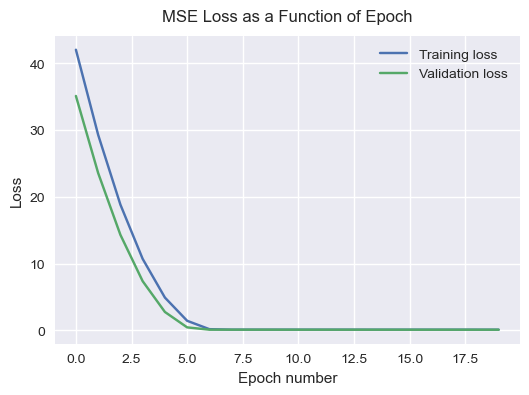

In [7]:
from visualize import plot_loss, plot_accuracy

plot_loss(loss_list, val_loss_list)